In [ ]:
!pip install -U torchtext==0.17.2

In [ ]:
!pip install contractions

In [ ]:
!pip install vaderSentiment

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed)

## Load Data and EDA

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/My Drive/code/Tweet/train.csv', encoding='latin-1')
test = pd.read_csv('/content/drive/My Drive/code/Tweet/test.csv', encoding='latin-1')

In [ ]:
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [ ]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

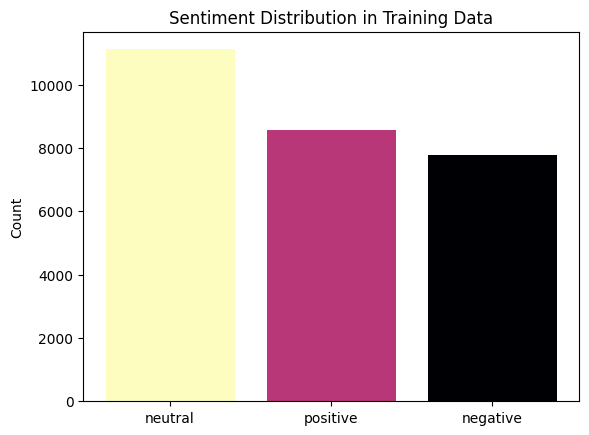

In [ ]:
sentiment_counts = train['sentiment'].value_counts()

ranks = np.argsort(np.argsort(sentiment_counts.values))
colors = plt.cm.magma (ranks / max(ranks))

plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.ylabel("Count")
plt.title("Sentiment Distribution in Training Data")
plt.show()

Use only text and sentiment columns

In [ ]:
col = ['text', 'sentiment']

train_df = train[col]
test_df = test[col]

## Prepare Sentiment Labels

In [ ]:
sentiment_to_index = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
  }

train_df.loc[:, 'sentiment'] = train_df['sentiment'].map(sentiment_to_index)
test_df.loc[:, 'sentiment'] = test_df['sentiment'].map(sentiment_to_index)

In [ ]:
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


## Prepare Text Data

### Adjust Words based on REGEX

In [ ]:
def remove_special_character(text):
    text=re.sub('<.*?>', ' ', text)
    text=re.sub('<.*>','',text)
    text=re.sub('http\S+|https\S+|www\S+','',text)
    text=re.sub('@\S+|#\S+','',text)
    # Keep apostrophes only if inside words (like "I'm", "don't")
    text = re.sub('`', "'",  text)
    text = re.sub(r"[^\w\s']", '', text)
    return text

In [ ]:
import contractions

# couldn't -> could not
def expand_contractions(text):
    text = contractions.fix(text)
    return text

In [ ]:
train_df.loc[:, 'text'] = train_df['text'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)
test_df.loc[:, 'text'] = test_df['text'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)

In [ ]:
train_df.head()

,text,sentiment
0,i would have responded if i were going,1
1,sooo sad i will miss you here in san diego,0
2,my boss is bullying me,0
3,what interview leave me alone,0
4,sons of why could not they put them on the re...,0


### Tokenize

In [ ]:
train_data = []

for _, row in train_df.iterrows():
    text = row["text"]
    tokens = word_tokenize(text)
    train_data.append([row["sentiment"], tokens])

In [ ]:
train_data[:3]

[[1, ['i', 'would', 'have', 'responded', 'if', 'i', 'were', 'going']],
 [0,
  ['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego']],
 [0, ['my', 'boss', 'is', 'bullying', 'me']]]

In [ ]:
test_data = []

for _, row in test_df.iterrows():
    text = row["text"]
    tokens = word_tokenize(text)
    test_data.append([row["sentiment"], tokens])

In [ ]:
test_data[:3]

[[1, ['last', 'session', 'of', 'the', 'day']],
 [2,
  ['shanghai',
   'is',
   'also',
   'really',
   'exciting',
   'precisely',
   'skyscrapers',
   'galore',
   'good',
   'tweeps',
   'in',
   'china',
   'sh',
   'bj']],
 [0,
  ['recession',
   'hit',
   'veronique',
   'branquinho',
   'she',
   'has',
   'to',
   'quit',
   'her',
   'company',
   'such',
   'a',
   'shame']]]

### Remove stop words and Apply Lemmatizer

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy

nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words("english"))

def preprocess_tokens(tokens):
    processed_tokens = []
    for token_list in tokens:
        label, words = token_list[0], token_list[1]
        filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords

        lemmatized_words = []
        for doc in nlp.pipe(filtered_words, disable=["parser", "ner"]):
            lemmatized_words.append(doc[0].lemma_)

        processed_tokens.append([label, lemmatized_words])
    return processed_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_processed = preprocess_tokens(train_data)
train_processed[:5]

[[1, ['would', 'respond', 'go']],
 [0, ['sooo', 'sad', 'miss', 'san', 'diego']],
 [0, ['boss', 'bully']],
 [0, ['interview', 'leave', 'alone']],
 [0, ['son', 'could', 'put', 'release', 'already', 'buy']]]

In [ ]:
test_processed = preprocess_tokens(test_data)
test_processed[:5]

[[1, ['last', 'session', 'day']],
 [2,
  ['shanghai',
   'also',
   'really',
   'exciting',
   'precisely',
   'skyscraper',
   'galore',
   'good',
   'tweep',
   'china',
   'sh',
   'bj']],
 [0,
  ['recession', 'hit', 'veronique', 'branquinho', 'quit', 'company', 'shame']],
 [2, ['happy', 'birthday']],
 [2, ['like']]]

### Build Vocabulary (Word-to-Index Mapping)

In [ ]:
def yield_tokens(data):
    for d in data:
        yield d[1]

vocab = build_vocab_from_iterator(yield_tokens(train_processed), specials=["<unk>"]) # adds a special token <unk> (for unknown words).
vocab.set_default_index(index=vocab["<unk>"]) # unknown words (words not in vocab) get mapped to <unk> (index 0).

### Encode text

In [ ]:
encoded_train = [[label, vocab(tokens)] for label, tokens in train_processed]
encoded_train[:5]

[[1, [28, 1189, 1]],
 [0, [296, 60, 22, 1104, 1860]],
 [0, [1003, 3720]],
 [0, [766, 68, 365]],
 [0, [580, 54, 181, 755, 128, 146]]]

In [ ]:
test_encoded = [[label, vocab(tokens)] for label, tokens in test_processed]
print(test_encoded[:5])

[[1, [44, 903, 3]], [2, [0, 163, 24, 703, 18250, 0, 6484, 5, 1265, 1719, 7599, 0]], [0, [4149, 287, 0, 0, 1023, 583, 592]], [2, [19, 133]], [2, [7]]]


### Batch Collation

In [ ]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(_label)
         processed_text = torch.tensor(_text, dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0)) # Stores sequence length in offsets to track where each sample starts

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0) # Store cumulative sequence positions.
    text_list = torch.cat(text_list)

    return label_list.to(device), text_list.to(device), offsets.to(device)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

False


### Create PyTorch DataLoader

In [ ]:
batch_size = 32
num_class = 3

train_encoded, val_encoded = train_test_split(encoded_train, test_size=0.05, shuffle=True)

train_loader = DataLoader(train_encoded, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_encoded, batch_size=64, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_encoded, batch_size=64, shuffle=False, collate_fn=collate_batch)

## Data Prediction by NLTK SentimentIntensityAnalyzer

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [ ]:
# Define ranges for tuning
pos_thresholds = np.arange(0.3, 0.35, 0.01)
neg_thresholds = np.arange(0.01 ,0.05, 0.005)

best_f1 = 0
best_thresholds = (0, 0)

for pos_t in pos_thresholds:
    for neg_t in neg_thresholds:
        test_labels = []
        test_predict = []

        # Convert tokenized words to text and get sentiment score
        def get_sentiment(words):
            text = ' '.join(words)
            scores = analyzer.polarity_scores(text)

            if scores['pos'] > scores['neg'] + pos_t:
                return 2  # Positive
            elif scores['neg'] > scores['pos'] + neg_t:
                return 0  # Negative
            else:
                return 1  # Neutral

        # Generate predictions for test set
        for label, words in test_processed:
            sentiment = get_sentiment(words)

            test_labels.append(label)
            test_predict.append(sentiment)

        # Evaluate performance
        report = classification_report(test_labels, test_predict, output_dict=True)
        f1_macro = report['macro avg']['f1-score']  # Use macro F1-score for balance

        if f1_macro > best_f1:
            best_f1 = f1_macro
            best_thresholds = (pos_t, neg_t)
            best_predict = test_predict.copy()

        print(f"Pos Threshold: {pos_t:.4f}, Neg Threshold: {neg_t:.4f}, F1-Score: {f1_macro:.4f}")

print(f"Best Thresholds: Positive = {best_thresholds[0]:.4f}, Negative = {best_thresholds[1]:.4f}, Best F1-Score = {best_f1:.4f}")

Pos Threshold: 0.3000, Neg Threshold: 0.0100, F1-Score: 0.6613
Pos Threshold: 0.3000, Neg Threshold: 0.0150, F1-Score: 0.6612
Pos Threshold: 0.3000, Neg Threshold: 0.0200, F1-Score: 0.6618
Pos Threshold: 0.3000, Neg Threshold: 0.0250, F1-Score: 0.6620
Pos Threshold: 0.3000, Neg Threshold: 0.0300, F1-Score: 0.6598
Pos Threshold: 0.3000, Neg Threshold: 0.0350, F1-Score: 0.6602
Pos Threshold: 0.3000, Neg Threshold: 0.0400, F1-Score: 0.6602
Pos Threshold: 0.3000, Neg Threshold: 0.0450, F1-Score: 0.6588
Pos Threshold: 0.3100, Neg Threshold: 0.0100, F1-Score: 0.6626
Pos Threshold: 0.3100, Neg Threshold: 0.0150, F1-Score: 0.6626
Pos Threshold: 0.3100, Neg Threshold: 0.0200, F1-Score: 0.6631
Pos Threshold: 0.3100, Neg Threshold: 0.0250, F1-Score: 0.6633
Pos Threshold: 0.3100, Neg Threshold: 0.0300, F1-Score: 0.6611
Pos Threshold: 0.3100, Neg Threshold: 0.0350, F1-Score: 0.6615
Pos Threshold: 0.3100, Neg Threshold: 0.0400, F1-Score: 0.6615
Pos Threshold: 0.3100, Neg Threshold: 0.0450, F1-Score:

In [ ]:
class_names = ['Negative', 'Neutral', 'Positive']
report2 = classification_report(test_labels, best_predict, target_names=class_names)
print(report2)

              precision    recall  f1-score   support

    Negative       0.72      0.59      0.65      1001
     Neutral       0.62      0.68      0.65      1430
    Positive       0.68      0.71      0.69      1103

    accuracy                           0.66      3534
   macro avg       0.67      0.66      0.66      3534
weighted avg       0.67      0.66      0.66      3534



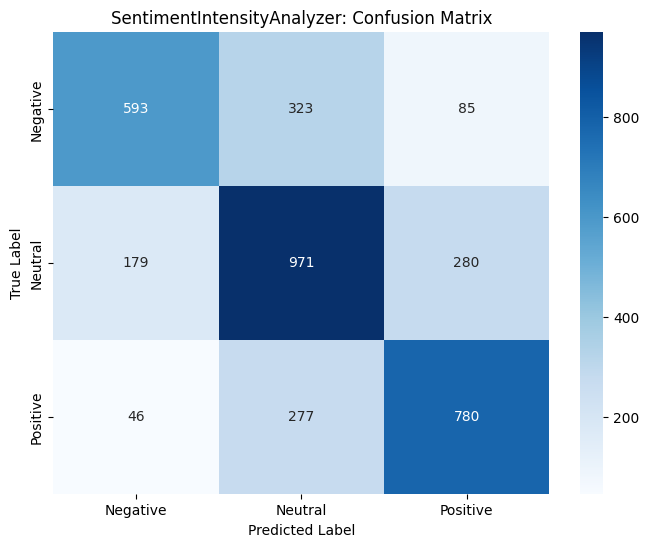

In [ ]:
cm2 = confusion_matrix(test_labels, best_predict)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("SentimentIntensityAnalyzer: Confusion Matrix")
plt.show()